In [1]:
#Importar imágenes
from skimage import io
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
from os import walk
from os import path
import csv

def csvReader(csvPath):
    rows = []
    with open(csvPath, newline='') as csvfile:
        perfiles = csv.reader(csvfile, delimiter=',', quoting=csv.QUOTE_NONNUMERIC)
        for row in perfiles:
            rows.append(row)
    return rows  

basePath = "C:\\Users\\Andres\\Documents\\GitHub\\Perikymata2017\\prototypes\\imagenesParaEnviar\\"

packs = list()
imgs= list()
masks = list()
filtered = list()
csvs = list()

for root, dirs, files in walk(basePath):
    pack = dict()
    for name in files:
        if 'original' in name:
            pack['original'] = path.join(root, name)
            imgs.append(io.imread(path.join(root, name)))
        elif 'marcado' in name:
            pack['marcado'] = path.join(root, name)
            masks.append(io.imread(path.join(root, name)))
        elif 'filtrado' in name:
            pack['filtrado'] = path.join(root, name)
            filtered.append(io.imread(path.join(root, name)))
        elif 'csv' in name:
            pack['csv'] = path.join(root, name)
            csvs.append(csvReader(path.join(root, name)))
    packs.append(pack) 
    
#Eliminamos el primer elemento porque no contiene nada
if packs[0] == []:
    packs.pop(0);  

In [2]:
from skimage.color import rgb2lab,gray2rgb
from skimage.morphology import skeletonize
from skimage.color import rgb2gray

"Función de Ismael"
def distancia_al_rojo(img, pixel):
        """
        Metodo para:
        Pasamos la imagen al espacio de color RGB y nos quedamos con el canal rojo
        Pasamos la imagen al espacio de color HSV
        Normalizamos la imagen del espacio de color HSV para utilizar que distancia 
        al rojo tenemos y poder hacer el theshold.
        
        @param img: imagen original leida anteriormente.
        @return: distance_red: distancia de cada pixel al rojo para luego hacer el threshold.
        
        """ 
        r,g,b = pixel        
        g,v,b=rgb2lab([[[r/255,g/255,b/255]]])[0][0]
        
        lab=rgb2lab(img)
        distance_red=abs(lab - [g,v,b]).mean(axis=2)
        return distance_red

<IPython.core.display.Javascript object>


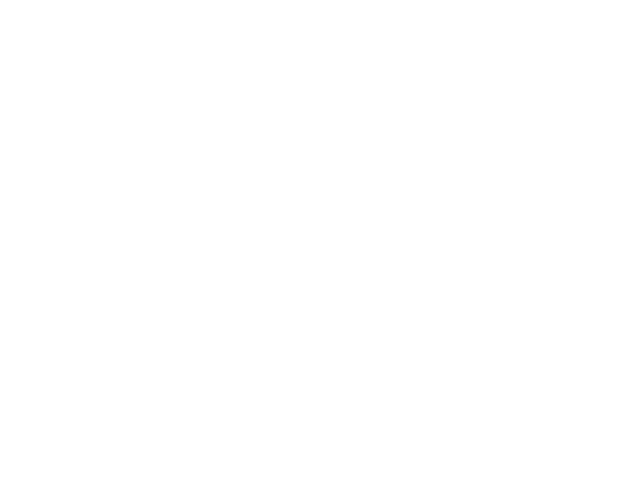

<IPython.core.display.Javascript object>


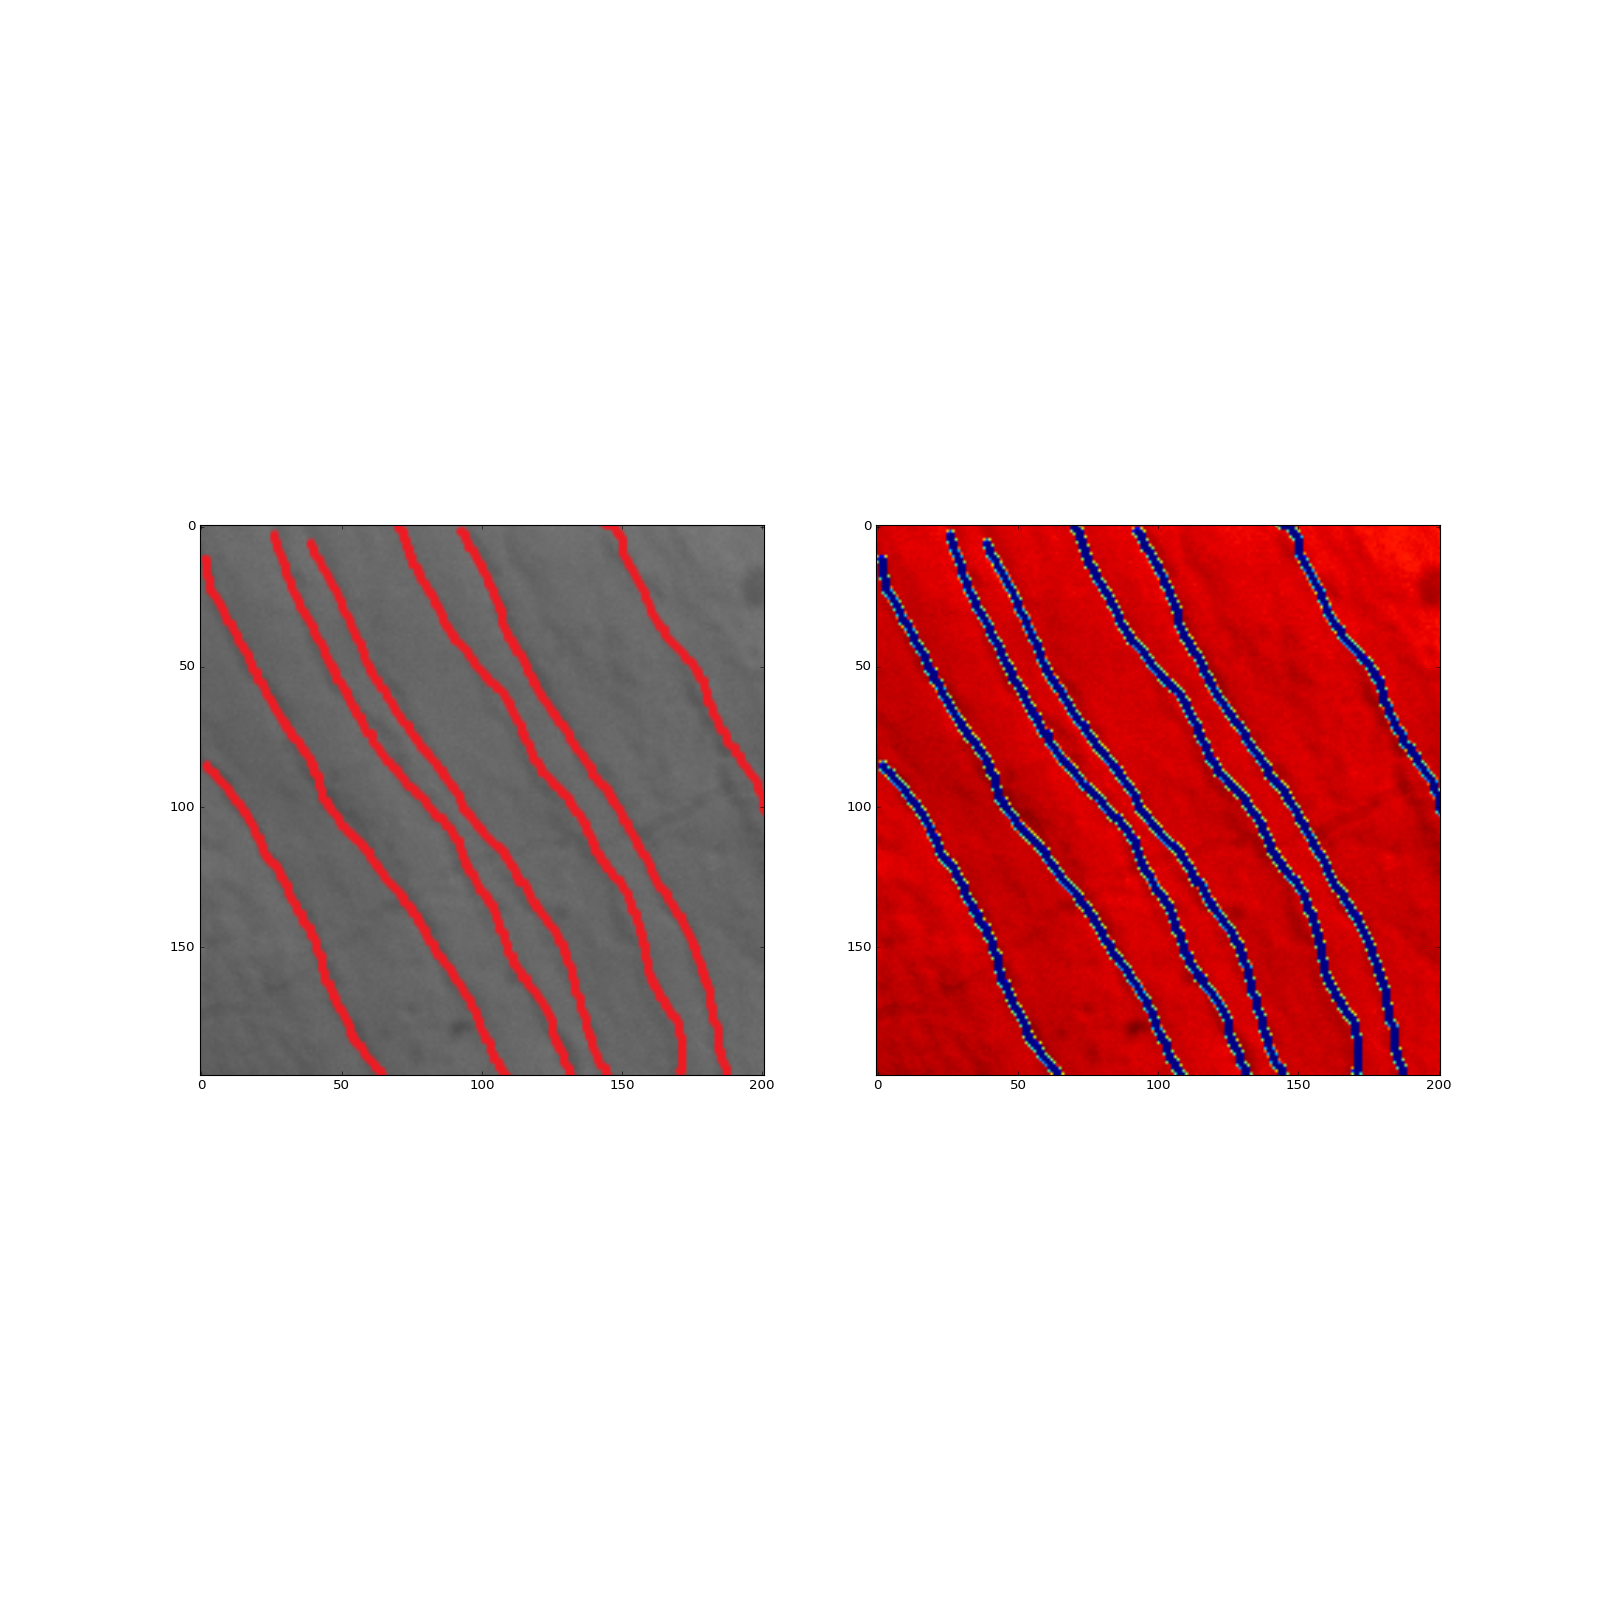

In [3]:
# Máscara
mskRojo=distancia_al_rojo(masks[0], [255, 0, 0])
plt.figure();
f, axes = plt.subplots(1,2,figsize=(20, 20));
axes[0].imshow(masks[0]);
axes[1].imshow(mskRojo);

Threshold: 18.138703652


<IPython.core.display.Javascript object>


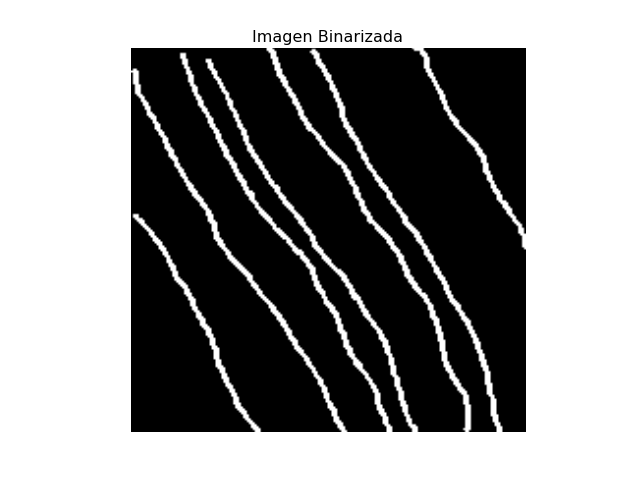

In [4]:
import skimage.filters as fil
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

# En principio usaremos threshold_li pero podemos observar como varía el threshold con otros métodos
def aplicarUmbral(img, TipoUmbral):
    threshold = None;
    if TipoUmbral == 'Li':
        threshold = fil.threshold_li(img);
    elif TipoUmbral == 'Isodata':
        threshold = fil.threshold_isodata(img);
    elif TipoUmbral == 'Otsu':
        threshold = fil.threshold_otsu(img);
    elif TipoUmbral == 'Yen':
        threshold = fil.threshold_yen(img);
    
    print('Threshold:',threshold);
    plt.figure();
    plt.axis('off');
    plt.title('Imagen Binarizada');
    plt.imshow((img<threshold), cmap='gray');
        
interact(aplicarUmbral, img=fixed(mskRojo), TipoUmbral=('Li', 'Isodata', 'Otsu', 'Yen'));

In [5]:
#Skeletonizar mascara
binMask = mskRojo<fil.threshold_li(mskRojo);
skelMask = skeletonize(binMask);

In [6]:
#Binarizar imagen de muestra y esqueletonizarla
from skimage.color import rgb2grey
from skimage import exposure 
from skimage.restoration import denoise_tv_chambolle

from _frangi import frangi, hessian
from skimage.filters import threshold_li
from skimage import morphology
from skimage.morphology import skeletonize
import warnings as war

def tratamientoImagen(img):
    """
    Esta función sirve para preparar la imagen que vamos a comparar con la máscara
    Aplica una serie de filtros a una imagen, la binariza y la esqueletoniza.
    @param img: imagen de muestra a comparar con la máscara.
    @return no_smallF: imagen esqueletonizada sin objetos pequeños.
    """
    with war.catch_warnings():
        war.simplefilter("ignore")
        img = rgb2grey(img)
        imgAdapted = exposure.equalize_adapthist(img, clip_limit=0.91,nbins =100)
        imgAdaptedDenoise = denoise_tv_chambolle(imgAdapted, weight=0.1)
    
        frangiImg = frangi(imgAdaptedDenoise)
        threshF = threshold_li(frangiImg)
        thresholdedF = frangiImg >= threshF
        skF=skeletonize(thresholdedF)
        #Probamos con 70
        no_smallF = morphology.remove_small_objects(skF, min_size=70,connectivity =100)

    return no_smallF

In [7]:
def tratamientoMascara(mask):
    """
    Función para binarizar la máscara y esqueletonizarla
    @param mask mascara
    @return skelMask mascara binarizada y esqueletonizada
    """
    mskRojo = distancia_al_rojo(mask, [255, 0, 0])
    binMask = mskRojo<fil.threshold_li(mskRojo)
    skelMask = skeletonize(binMask);
    return skelMask   

<IPython.core.display.Javascript object>


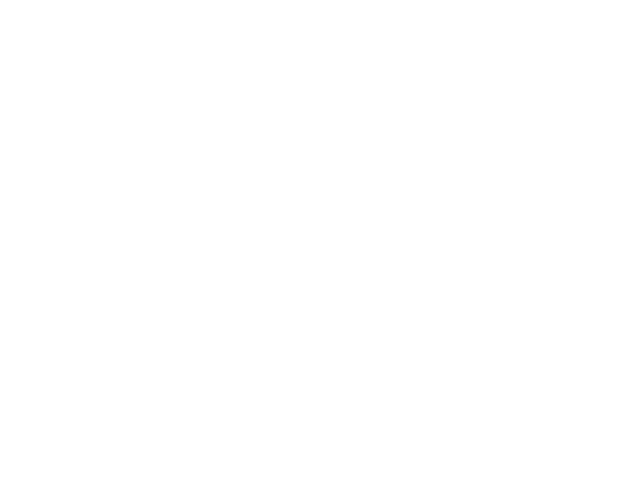

<IPython.core.display.Javascript object>


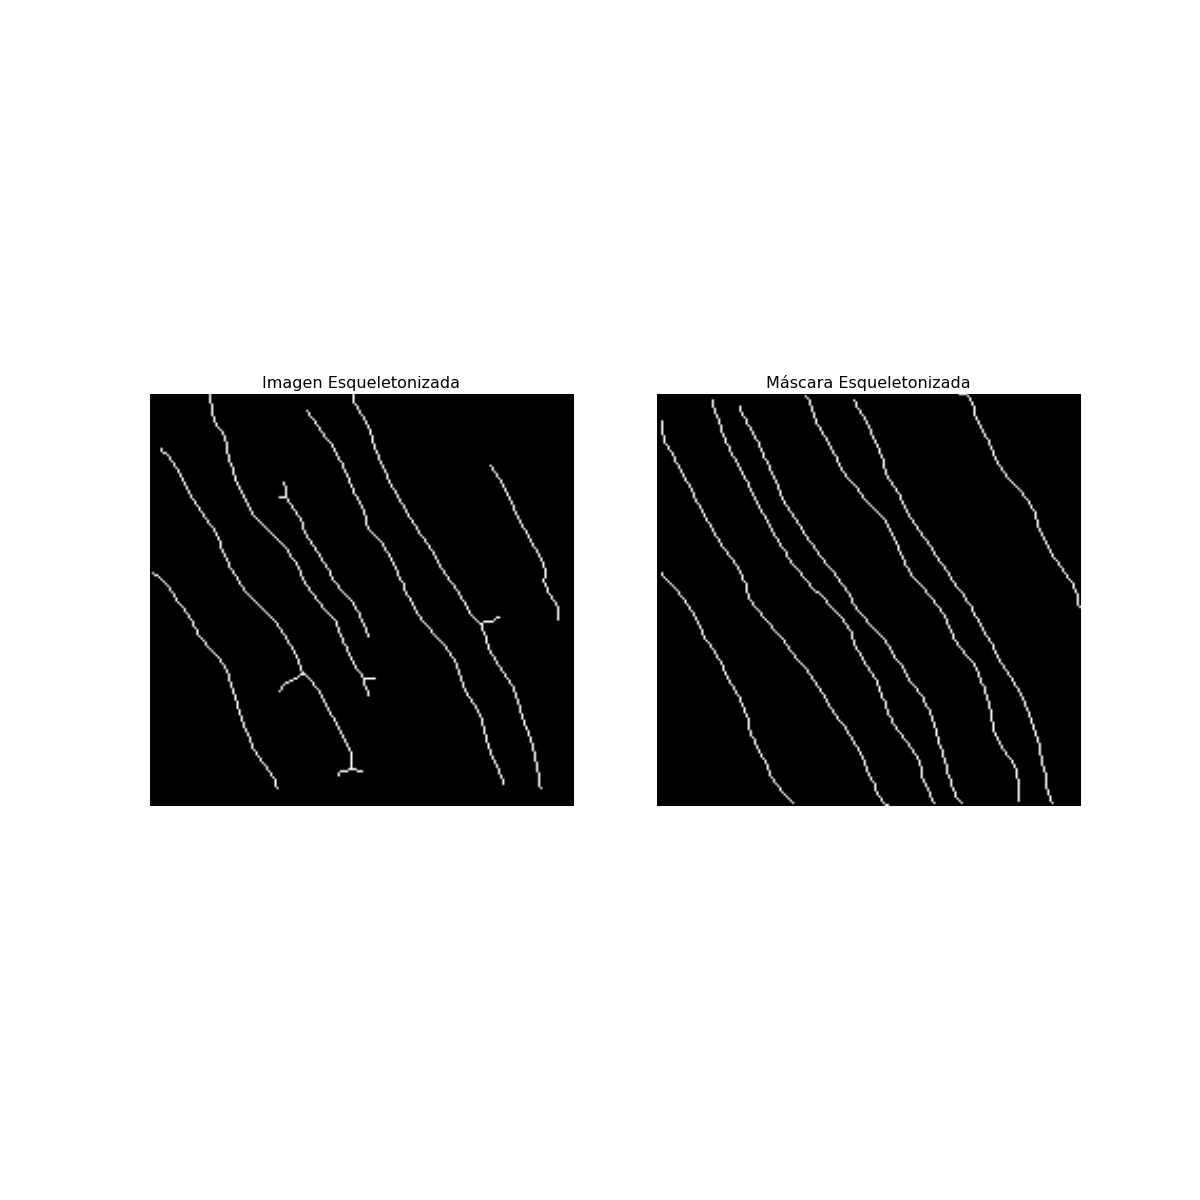

In [8]:
#Imagen esqueletonizada
skelImg = tratamientoImagen(imgs[0]);
plt.figure();
f, axes = plt.subplots(1,2,figsize=(15, 15));
for axe in axes:
    axe.axis('off');

axes[0].set_title("Imagen Esqueletonizada");
axes[1].set_title("Máscara Esqueletonizada");

axes[0].imshow(skelImg, cmap='gray');
axes[1].imshow(skelMask, cmap='gray');

In [9]:
#Evaluar distancia
# from wiki. Pone str pero funciona con listas tb
# Fuente: https://es.wikipedia.org/wiki/Distancia_de_Levenshtein#Python
def distance(str1, str2):
    """
    Distancia de Levenshtein
    """
    d=dict()
    for i in range(len(str1)+1):
        d[i]=dict()
        d[i][0]=i
    for i in range(len(str2)+1):
        d[0][i] = i
    for i in range(1, len(str1)+1):
        for j in range(1, len(str2)+1):
            d[i][j] = min(d[i][j-1]+1, d[i-1][j]+1, d[i-1][j-1]+(not str1[i-1] == str2[j-1]))
    return d[len(str1)][len(str2)]

In [10]:
def getDifferences(img1, img2, csvItem):
    """
    Devuelve una lista con las diferencias en cada linea de las imágenes
    @param img1 imagen 1
    @param img2 imagen 2
    @param csv csv donde se encuentran los pixels de la imagen que hay que evaluar
    @return lista de diferencias
    """
    #Obtener los puntos de las imagenes a evaluar segun los pixels marcados en el csv
    pixels1 = list()
    pixels2 = list()
    for row in csvItem:
        pixels1.append(img1[int(row[1])][int(row[0])])
        pixels2.append(img2[int(row[1])][int(row[0])])
    return distance(pixels1, pixels2)

In [26]:
from skimage.feature import hessian_matrix, hessian_matrix_eigvals
from skimage import img_as_float
from scipy.ndimage import gaussian_filter
from skimage.morphology import reconstruction
from skimage import morphology
from skimage.morphology import binary_erosion,diamond
from skimage.morphology import skeletonize

def tratamientoAlternativo(img):
    """
    Forma Ismael
    @param img: imagen de muestra a comparar con la máscara.
    @return no_smallF: imagen esqueletonizada sin objetos pequeños.
    """
    with war.catch_warnings():
        war.simplefilter("ignore")
        img = rgb2grey(img)
        imgAdapted = exposure.equalize_adapthist(img, clip_limit=0.91,nbins =100)
        imgAdaptedDenoise = denoise_tv_chambolle(imgAdapted, weight=0.1)
    
        hxx, hxy, hyy = hessian_matrix(imgAdaptedDenoise, sigma=1.85,mode='wrap',cval=0.11)
        i1, i2 = hessian_matrix_eigvals(hxx, hxy, hyy) # @UnusedVariable

        edges = img_as_float(i1)
        filtered = gaussian_filter(edges, 1)
        
        thresh3 = threshold_li(edges)
        thresholded3 = edges >= thresh3
        
        no_small = morphology.remove_small_objects(thresholded3, min_size=155,connectivity =100)
        selem=diamond(1.9)
        dil=binary_erosion(no_small, selem, out=None)
        skl=skeletonize(dil)
        no_small2 = morphology.remove_small_objects(skl, min_size=0,connectivity =100)
    return no_small2

In [12]:
skelMask = skelMask.astype(int)
skelImg = skelImg.astype(int)

differences = getDifferences(skelImg, skelMask, csvs[0])

print('Primer pack:', differences)

Primer pack: 6


# Resultados generales:

In [13]:
# Máscaras tratadas
processedMask = list(map(lambda msc: tratamientoMascara(msc), masks))

In [14]:
# Imagenes originales tratadas
processedOriginal = list(map(lambda img: tratamientoImagen(img), imgs))

In [15]:
# Diferencias del nuevo método con la máscara
differencesNew = (list(map(lambda img, msc, csvItem: getDifferences(img, msc, csvItem), processedOriginal, processedMask, csvs)))
print('Diferencias en cada carpeta entre máscara y la imagen filtrada con el nuevo método:')
print(differencesNew, np.mean(differencesNew))

Diferencias en cada carpeta entre máscara y la imagen filtrada con el nuevo método:
[6, 10, 10, 6, 15] 9.4


In [16]:
# Diferencias del antiguo método con la máscara???
processedOld = list(map(lambda oldImg: tratamientoImagen(oldImg), filtered))
differencesOld = (list(map(lambda oldImg, msc, csvItem: getDifferences(oldImg, msc, csvItem), processedOriginal, processedOld, csvs)))
print('Diferencias en cada carpeta entre máscara y y la imagen filtrada con el método viejo:')
print(differencesOld, np.mean(differencesOld))

Diferencias en cada carpeta entre máscara y y la imagen filtrada con el método viejo:
[11, 31, 9, 4, 11] 13.2


In [27]:
# Imagenes originales metodo Ismael
processedIsmael = list(map(lambda img: tratamientoAlternativo(img), imgs))

In [28]:
# Diferencias del método de Ismael con la máscara
differencesIsma = (list(map(lambda img, msc, csvItem: getDifferences(img, msc, csvItem), processedIsmael, processedMask, csvs)))
print('Diferencias en cada carpeta entre máscara y la imagen filtrada con el método de Ismael:')
print(differencesIsma, np.mean(differencesIsma))

Diferencias en cada carpeta entre máscara y la imagen filtrada con el método de Ismael:
[9, 38, 12, 7, 19] 17.0


In [29]:
imgFull1 = io.imread('FullImages\\Full_Image.png')
imgFull2 = io.imread('FullImages\\Filtered_Image.png')

imgFull1_normal= tratamientoImagen(imgFull1);
imgFull2_normal = tratamientoImagen(imgFull2);

imgFull1_alternativo = tratamientoAlternativo(imgFull1)
imgFull2_alternativo = tratamientoAlternativo(imgFull2)

<IPython.core.display.Javascript object>


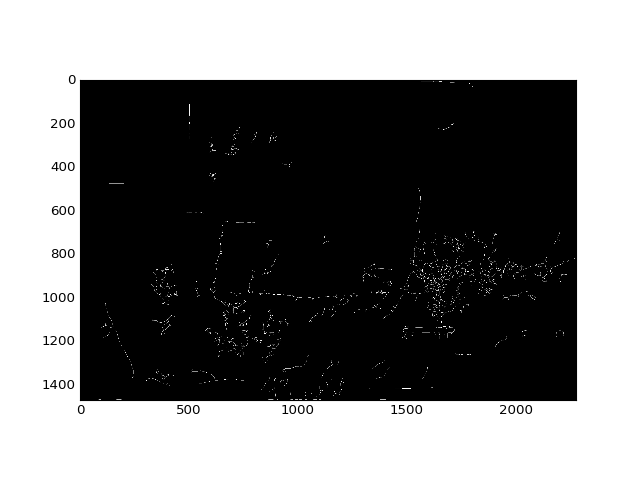

In [20]:
plt.figure()
plt.imshow(imgFull1_normal, cmap='gray')

<IPython.core.display.Javascript object>


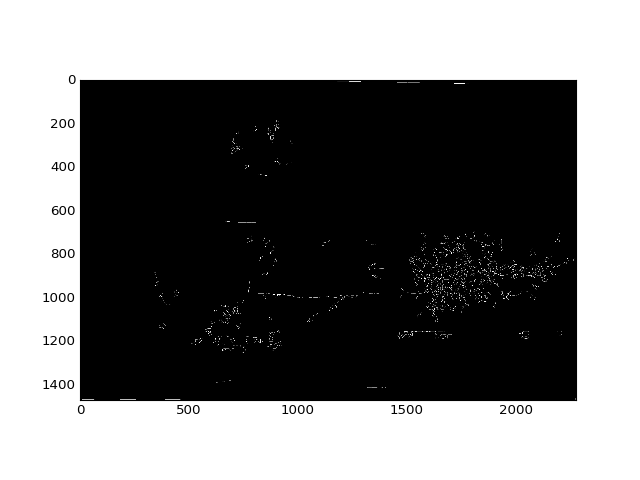

In [21]:
plt.figure()
plt.imshow(imgFull1_alternativo, cmap='gray')

<IPython.core.display.Javascript object>


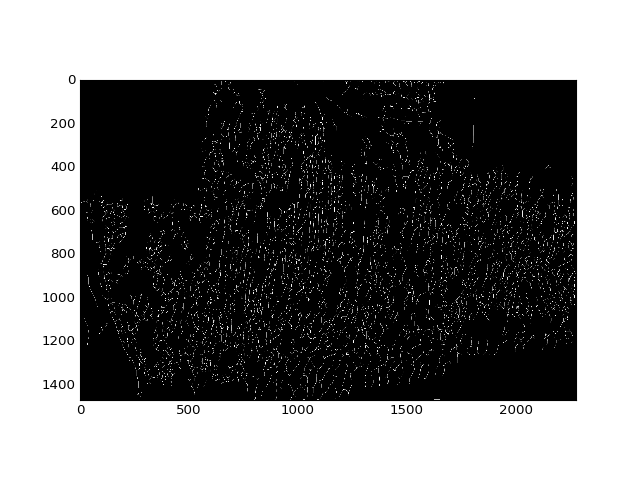

In [25]:
plt.figure()
plt.imshow(imgFull2_normal, cmap='gray')

<IPython.core.display.Javascript object>


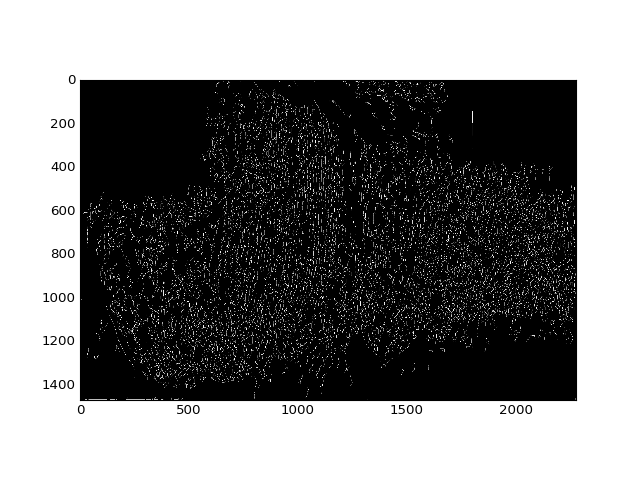

In [23]:
plt.figure()
plt.imshow(imgFull2_alternativo, cmap='gray')